<a href="https://colab.research.google.com/github/Cesare-Caputo/PyPSA-gridtracer/blob/main/pypsa_gridtracer_costs_raster_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#setup

In [ ]:
!pip install geopandas
!pip install folium
!pip install rtree
!pip install rasterio

     |████████████████████████████████| 1.0 MB 4.2 MB/s 
     |████████████████████████████████| 16.7 MB 58.0 MB/s 
     |████████████████████████████████| 6.3 MB 43.7 MB/s 
     |████████████████████████████████| 1.0 MB 4.1 MB/s 
     |████████████████████████████████| 19.3 MB 1.3 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


##helper functions


In [ ]:
from osgeo import osr, gdal
import numpy as np
from gdalconst import *
from shapely.geometry import Polygon, Point
import geopandas as gpd
import folium
import os
import rtree
from tqdm import tqdm
# import pygeos


def make_polygon_list(path, resume=None):
    """
    Creates GeoDataFrame, checks the tif files in a desired dir
    and adds their geometries (with respective file name) as row
    to GeoDataFrame

    Parameters
    -----------

    path : (str)
        directory with tif files

    resume : (gpd.GeoDataFrame or None)
        if None: initializes new GeoDataFrame
        else: appends to given one

    Returns
    ----------
    coverage : gpd.GeoDataFrame
        df with geometries of tif files

    """

    tif_files = []

    # iterate over all .tif files in desired dir
    for filename in os.listdir(path):
        if filename.endswith(".tif"):
            tif_files.append(os.path.join(path, filename))

    tif_files = [os.path.join(path, tif_file) for tif_file in tif_files]

    # add data to existing dataframe if desired
    if resume is None:
        coverage = gpd.GeoDataFrame({"filename": [], "geometry": []}).set_crs(epsg=4326)
    else:
        coverage = resume.set_crs(epsg=4326)

    # extract geometries of .tif files and add to geodataframe
    for file in tqdm(tif_files):
        info = gdal.Info(file, format="json")
        corners = info["cornerCoordinates"]
        poly = Polygon((
                    corners["upperLeft"],
                    corners["upperRight"],
                    corners["lowerRight"],
                    corners["lowerLeft"]
                        ))
        coverage = coverage.append({"filename": file, "geometry": poly}, ignore_index=True)

    return coverage


#explore GH coverage

In [ ]:
base = '/content/drive/MyDrive/PyPSA_Africa_images/maxar'
path_GH = os.path.join(base, 'ghana/raw')
coverage=None
coverage = make_polygon_list(path_GH)

100%|██████████| 52/52 [00:51<00:00,  1.01it/s]


In [ ]:
map_start = coverage.dissolve().centroid
map_start

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


0    POINT (-1.87253 9.45276)
dtype: geometry

In [ ]:
import folium

fn = 'gh_tif_coverage.geojson'
coverage.to_file(fn, driver='GeoJSON')

m = folium.Map(
    location=[-1.87, 9.45],
    tiles="cartodbpositron",
    zoom_start=5,
)

folium.GeoJson(fn, name="geojson").add_to(m)

m

In [ ]:
towers_GH = os.path.join(base, "ghana/raw/GH_raw_towers.geojson")
towers_GH = gpd.read_file(towers_GH)

In [ ]:
hits_GH = gpd.sjoin(towers_GH, coverage, how="inner").set_crs(epsg=4326)
print(len(hits_GH))

hits_GH = hits_GH.drop(["index_right"], axis=1)

4547


In [ ]:
hits_GH

,id,tags.power,tags.material,tags.height,tags.structure,tags.line_management,Type,Country,geometry,filename
3,3.063970e+09,tower,None,None,None,None,Node,GH,POINT (-2.34855 8.85587),/content/drive/MyDrive/PyPSA_Africa_images/max...
4,3.063970e+09,tower,None,None,None,None,Node,GH,POINT (-2.41069 8.92856),/content/drive/MyDrive/PyPSA_Africa_images/max...
157,6.299637e+09,tower,None,None,None,None,Node,GH,POINT (-2.30691 8.69095),/content/drive/MyDrive/PyPSA_Africa_images/max...
237,3.063969e+09,tower,None,None,None,None,Node,GH,POINT (-2.33556 8.81249),/content/drive/MyDrive/PyPSA_Africa_images/max...
405,3.063969e+09,tower,None,None,None,None,Node,GH,POINT (-2.32309 8.75970),/content/drive/MyDrive/PyPSA_Africa_images/max...
...,...,...,...,...,...,...,...,...,...,...
11342,2.622444e+09,tower,None,None,None,None,Node,GH,POINT (-1.27925 9.11115),/content/drive/MyDrive/PyPSA_Africa_images/max...
11397,2.622444e+09,tower,None,None,None,None,Node,GH,POINT (-1.33825 9.01048),/content/drive/MyDrive/PyPSA_Africa_images/max...
11449,2.622276e+09,tower,None,None,None,None,Node,GH,POINT (-1.30005 9.07561),/content/drive/MyDrive/PyPSA_Africa_images/max...
1578,2.622444e+09,tower,None,None,None,None,Node,GH,POINT (-1.32736 9.02910),/content/drive/MyDrive/PyPSA_Africa_images/max...


In [ ]:
hits_GH.filename.unique()
max_imgs = 0
max_tif = None
for tif in hits_GH.filename.unique():
    # print(tif)
    curr = hits_GH.loc[hits_GH['filename'] == tif]
    # print(curr)
    if len(curr) > max_imgs:
        max_imgs = len(curr)
        max_tif = tif

print('max images')
print(max_imgs)
print('file')
print(max_tif)

max images
380
file
/content/drive/MyDrive/PyPSA_Africa_images/maxar/ghana/raw/10500100103B0300.tif


In [ ]:
targets_df = hits_GH.loc[hits_GH['filename'] == max_tif]
targets_df.head()

,id,tags.power,tags.material,tags.height,tags.structure,tags.line_management,Type,Country,geometry,filename
18,6.299636e+09,tower,None,None,None,None,Node,GH,POINT (-2.14599 8.44320),/content/drive/MyDrive/PyPSA_Africa_images/max...
26,3.063969e+09,tower,None,None,None,None,Node,GH,POINT (-2.14358 8.43817),/content/drive/MyDrive/PyPSA_Africa_images/max...
82,3.063969e+09,tower,None,None,None,None,Node,GH,POINT (-2.06821 8.20735),/content/drive/MyDrive/PyPSA_Africa_images/max...
108,3.063969e+09,tower,None,None,None,None,Node,GH,POINT (-2.13402 8.23473),/content/drive/MyDrive/PyPSA_Africa_images/max...
294,6.299915e+09,tower,None,None,None,None,Node,GH,POINT (-2.05582 8.20089),/content/drive/MyDrive/PyPSA_Africa_images/max...


In [ ]:
import matplotlib.pyplot as plt
_, ax = plt.subplots(1, 1, figsize=(16, 9))
targets_df.plot(ax=ax)
coverage.plot(ax=ax, alpha=0.1)
plt.show()

In [ ]:
aoi = coverage.loc[coverage['filename'] == max_tif]
aoi.total_bounds

array([-2.1770943,  7.9835061, -1.9918943,  9.0126198])

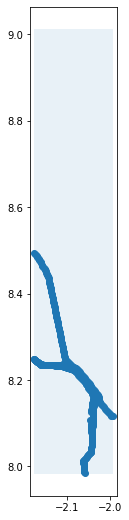

In [ ]:
import matplotlib.pyplot as plt
_, ax = plt.subplots(1, 1, figsize=(16, 9))
targets_df.plot(ax=ax)
aoi.plot(ax=ax, alpha=0.1)
plt.show()

#GF utils

In [ ]:
from pathlib import Path
import json

import geopandas as gpd
import rasterio
from rasterio.mask import mask


def save_raster(path, raster, affine, crs=None, nodata=0):
    """Save a raster to the specified file.
    Parameters
    ----------
    file : str
        Output file path
    raster : numpy.array
        2D numpy array containing raster values
    affine: affine.Affine
        Affine transformation for the raster
    crs: str, proj.Proj, optional (default EPSG4326)
        CRS for the raster
    """

    path = Path(path)
    if not path.parents[0].exists():
        path.parents[0].mkdir(parents=True, exist_ok=True)

    if not crs:
        crs = "+proj=latlong"

    filtered_out = rasterio.open(
        path,
        "w",
        driver="GTiff",
        height=raster.shape[0],
        width=raster.shape[1],
        count=1,
        dtype=raster.dtype,
        crs=crs,
        transform=affine,
        nodata=nodata,
    )
    filtered_out.write(raster, 1)
    filtered_out.close()

def estimate_mem_use(targets, costs):
    """Estimate memory usage in GB, probably not very accurate.
    Parameters
    ----------
    targets : numpy array
        2D array of targets.
    costs : numpy array
        2D array of costs.
    Returns
    -------
    est_mem : float
        Estimated memory requirement in GB.
    """

    # make sure these match the ones used in optimise below
    visited = np.zeros_like(targets, dtype=np.int8)
    dist = np.full_like(costs, np.nan, dtype=np.float32)
    prev = np.full_like(costs, np.nan, dtype=object)

    est_mem_arr = [targets, costs, visited, dist, prev]
    est_mem = len(pickle.dumps(est_mem_arr, -1))

    return est_mem / 1e9

In [ ]:
from shapely import geometry
import shapely
# note that these are for now specific to extrating tower data
def gdf_2_gridded_conversion_2(gdf, n_cells):
    xmin, ymin, xmax, ymax= gdf.total_bounds
  # how many cells for range of x values investigated - can be customized for y if needed
  #n_cells=30
    cell_size = (xmax-xmin)/n_cells
    # projection of the grid
    crs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"
    # create the cells in a loop
    grid_cells = []
    for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
        for y0 in np.arange(ymin, ymax+cell_size, cell_size):
            # bounds
            x1 = x0-cell_size
            y1 = y0+cell_size
            grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )
    cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'],
                                    crs=crs)


    merged = gpd.sjoin(gdf, cell, how='left', op='within')

    #clean_merge = merged.drop(labels =['tags.power', 'tags.material', 'tags.height', 'tags.structure',
        #'tags.line_management', 'Type', 'Country'], axis = 1)

    #clean_merge = merged.drop(labels =['tags.power', 'Type', 'Country'], axis = 1)
    #clean_merge = merged.loc[:, ['id', 'geometry', 'index_right']]

    clean_merge = merged
    ## removing nan which can cause error
    merged2 = clean_merge.dropna(axis = 0, how = 'any')

    return merged2 , cell

def gdf_2_binary_gridded_conversion_2(gdf, n_cells):
    merged2, cell = gdf_2_gridded_conversion_2(gdf, n_cells)

    # make a simple count variable that we can sum
    merged2['n_twr']=1
    # Compute stats per grid cell -- aggregate fires to grid cells with dissolve
    dissolve = merged2.dissolve(by="index_right", aggfunc="count")
    # put this into cell
    cell.loc[dissolve.index, 'n_twr'] = dissolve.n_twr.values


    return cell

def return_idx_twr_gridded(cell, n_cells): #cell here is df containing both shapely polygon grids and original tower point markers , ncells to number of cells in x coordinate system for now
  # total area for the grid
  gdf = cell
  xmin, ymin, xmax, ymax= gdf.total_bounds
  cell_size = (xmax-xmin)/n_cells

  gps = []
  #find location in grid ####
  for i in range(len(cell)):
    if cell["n_twr"][i] ==1:
      #print(i)
      twr_grid_cnt = list(cell.iloc[i].geometry.centroid.coords)
      yic = twr_grid_cnt[0][1]
      xic = twr_grid_cnt[0][0]
  #### now retrieve integer indexing #####
      yi = int((yic- ymin) / cell_size)
      xi = int((xic- xmin) / cell_size)

      gps.append((yi,xi))
  return gps


def pts_df_to_2d_target_array(cell, n_cells):

  gdf = cell
  xmin, ymin, xmax, ymax= gdf.total_bounds
  cell_size = (xmax-xmin)/n_cells

  # define number of x and y cells used for indexing
  nxcell = int((xmax - xmin) / cell_size)
  nycell = int((ymax - ymin) / cell_size)

  twr_pts_idx = return_idx_twr_gridded(cell, n_cells)

  points = twr_pts_idx
  targets = np.zeros((int(nycell+1), int(nxcell+1)))
  targets[tuple(np.array(points).T)] = 1
  #targets[tuple(np.array(points))] = 1
  #equal costs for all cells - excluding road info etc
  #costs = np.ones((int(nycell+1), int(nxcell+1)))

  ## flip to be consistent with original gridded
  t = np.flip(targets, 0)
  #c = np.flip(costs, 0)

  return t

#load inferred towers over same areas

In [ ]:
path = '/content/drive/MyDrive/PyPSA_Africa_images/models/outlier_detection/detected_gh_twr_test_1000_batch'
inferred_gh_twrs = gpd.read_file(path)
inferred_gh_twrs.head()

,tif,score,geometry
0,/content/drive/My Drive/PyPSA_Africa_images/ma...,0.691322,POINT (-2.17647 9.01199)
1,/content/drive/My Drive/PyPSA_Africa_images/ma...,0.454091,POINT (-2.17655 9.01207)
2,/content/drive/My Drive/PyPSA_Africa_images/ma...,0.772516,POINT (-2.13858 9.01169)
3,/content/drive/My Drive/PyPSA_Africa_images/ma...,0.402426,POINT (-2.13858 9.01169)
4,/content/drive/My Drive/PyPSA_Africa_images/ma...,0.986270,POINT (-2.12780 9.01230)


In [ ]:
path = '/content/drive/MyDrive/PyPSA_Africa_images/models/outlier_detection/detected_gh_twr_test_1000_batch_rev'
inferred_gh_twrs_rev = gpd.read_file(path)
inferred_gh_twrs_rev.head()

,tif,score,geometry
0,/content/drive/My Drive/PyPSA_Africa_images/ma...,0.507984,POINT (-2.02162 7.98465)
1,/content/drive/My Drive/PyPSA_Africa_images/ma...,0.776677,POINT (-2.00573 7.98470)
2,/content/drive/My Drive/PyPSA_Africa_images/ma...,0.154254,POINT (-2.00573 7.98470)
3,/content/drive/My Drive/PyPSA_Africa_images/ma...,0.922023,POINT (-1.99673 7.98596)
4,/content/drive/My Drive/PyPSA_Africa_images/ma...,0.256851,POINT (-2.01503 7.98603)


In [ ]:
combined_twr_df = inferred_gh_twrs.append(inferred_gh_twrs_rev, ignore_index = True)
combined_twr_df.head()

,tif,score,geometry
0,/content/drive/My Drive/PyPSA_Africa_images/ma...,0.691322,POINT (-2.17647 9.01199)
1,/content/drive/My Drive/PyPSA_Africa_images/ma...,0.454091,POINT (-2.17655 9.01207)
2,/content/drive/My Drive/PyPSA_Africa_images/ma...,0.772516,POINT (-2.13858 9.01169)
3,/content/drive/My Drive/PyPSA_Africa_images/ma...,0.402426,POINT (-2.13858 9.01169)
4,/content/drive/My Drive/PyPSA_Africa_images/ma...,0.986270,POINT (-2.12780 9.01230)


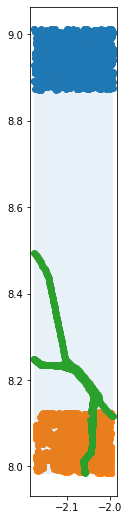

In [ ]:
import matplotlib.pyplot as plt
_, ax = plt.subplots(1, 1, figsize=(16, 9))
inferred_gh_twrs.plot(ax=ax)
inferred_gh_twrs_rev.plot(ax=ax)
aoi.plot(ax=ax, alpha=0.1)
targets_df.plot(ax=ax)
plt.show()

clearly there is too much noise to infer anything here, proceed first with filtering by score and then outlier removal

#old

In [ ]:
import os
from math import sqrt
import json
from pathlib import Path

import numpy as np
from scipy import signal

import fiona
import rasterio
from rasterio.mask import mask
from rasterio.features import rasterize
from rasterio import Affine
from rasterio.warp import reproject, Resampling

#import geopandas as gpd

# open files
base_dir = '/content/drive/My Drive/PyPSA_Africa_images'
tif = '10500100103B0300.tif'
in_dir = os.path.join(base_dir, 'maxar/ghana/raw')
fn =  os.path.join(in_dir,tif )
#ds = gdal.Open(fn)
#info = gdal.Info(fn, format="json")
#bands = [ds.GetRasterBand(i) for i in range(1, 4)]

# extract relevant geographical data
#transform = info["geoTransform"]
#affine = transform

rst = rasterio.open(fn)
print(rst.shape)
print(rst.transform)

(231295, 41624)
| 0.00, 0.00,-2.18|
| 0.00,-0.00, 9.01|
| 0.00, 0.00, 1.00|


19
103


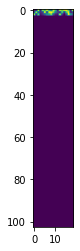

In [ ]:
import math

twrs = inferred_gh_twrs

pixel_size = .01

min_x, min_y, max_x, max_y = bounds = aoi['geometry'].total_bounds
w_px = math.ceil((max_x - min_x) / pixel_size)
h_px = math.ceil((max_y - min_y) / pixel_size)
print(w_px)
print(h_px)



#shape = w_px, h_px
shape = h_px, w_px # y determines rows, x determines columns
#transform = rasterio.transform.from_bounds(*twrs['geometry'].total_bounds, *shape)
transform = rasterio.transform.from_bounds(*bounds, *shape)


#twrs = inferred_gh_twrs

#twr_for_raster = [(row.geometry, row.weight) for _, row in roads.iterrows()]
#roads_for_raster = ((geometry, weight) for _, row in zip(roads.geometry, roads.weight))
#roads_for_raster = [(row.geometry, row.weight) for _, row in zip(roads.iterrows())]
# create tuples of geometry, value pairs, where value is the attribute value you want to burn


geom_value = ((geom,value) for geom, value in zip(twrs.geometry, twrs.score))
#shapes = ((geom,value) for geom, value in zip(roads.iterrows()

twr_raster = rasterize(
    geom_value,
    out_shape=shape,
    fill=0,
    default_value=0,
    all_touched=True,
    transform= transform,
)

twr_raster
plt.imshow(twr_raster, cmap='viridis')

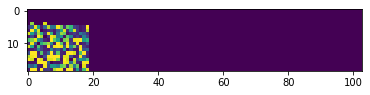

In [ ]:
flip_r_t = np.flip(twr_raster, 0)
#flip_r_t
plt.imshow(flip_r_t, cmap='viridis')

In [ ]:
import math

twrs = inferred_gh_twrs_rev

pixel_size = .01

min_x, min_y, max_x, max_y = bounds = aoi['geometry'].total_bounds
w_px = math.ceil((max_x - min_x) / pixel_size)
h_px = math.ceil((max_y - min_y) / pixel_size)
print(w_px)
print(h_px)



shape = h_px, w_px
#transform = rasterio.transform.from_bounds(*twrs['geometry'].total_bounds, *shape)
transform = rasterio.transform.from_bounds(*bounds, *shape)


#twrs = inferred_gh_twrs

#twr_for_raster = [(row.geometry, row.weight) for _, row in roads.iterrows()]
#roads_for_raster = ((geometry, weight) for _, row in zip(roads.geometry, roads.weight))
#roads_for_raster = [(row.geometry, row.weight) for _, row in zip(roads.iterrows())]
# create tuples of geometry, value pairs, where value is the attribute value you want to burn


geom_value = ((geom,value) for geom, value in zip(twrs.geometry, twrs.score))
#shapes = ((geom,value) for geom, value in zip(roads.iterrows()

twr_raster = rasterize(
    geom_value,
    out_shape=shape,
    fill=0,
    default_value=0,
    all_touched=True,
    transform= transform,
)

twr_raster
plt.imshow(twr_raster, cmap='viridis')

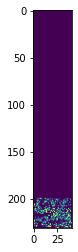

In [ ]:
import rasterio
from rasterio.enums import Resampling

base_dir = '/content/drive/My Drive/PyPSA_Africa_images'
tif = '10500100103B0300.tif'
in_dir = os.path.join(base_dir, 'maxar/ghana/raw')
fn =  os.path.join(in_dir,tif )

upscale_factor = .001 # need this otherwise colab crashes

with rasterio.open(fn) as dataset:

    # resample data to target shape
    data = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * upscale_factor),
            int(dataset.width * upscale_factor)
        ),
        resampling=Resampling.bilinear
    )

    # scale image transform
    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )

shape = data.shape[1] , data.shape[2]


twrs = inferred_gh_twrs_rev

geom_value = ((geom,value) for geom, value in zip(twrs.geometry, twrs.score))



twr_raster = rasterize(
    geom_value,
    out_shape=shape,
    fill=0,
    default_value=0,
    all_touched=True,
    transform= transform,
)

twr_raster
plt.imshow(twr_raster, cmap='viridis')

#rasterize towers

In [ ]:

import os
from math import sqrt
import json
from pathlib import Path

import numpy as np
from scipy import signal

import fiona
import rasterio
from rasterio.mask import mask
from rasterio.features import rasterize
from rasterio import Affine
from rasterio.warp import reproject, Resampling

def rasterize_inferred_twrs(tif, twrs, upscale_factor = .001, threshold = .1 ):
      """Convert the supplied tif file and inferred towers df to output an array of potential towers for grid reconstruction by algorithm.
    Parameters
    ----------
    tifs : str, Path
        Path to TIF file we want to use as base to rasterize
    twrs : GeoPandas.GeoDataframe, containing at least geometry and score colums
    upscale_factor: factor by which to downsample original raster file so we dont run out of memory (default=.001 for testing for now)
    treshold: float, optional, default of .1, accuracy score below which tower instances not considered once resampled to new upscaled size

    Returns
    -------
    twr_thresh : numpy array
        Array of cells of value 0 (no tower) or 1 (tower).
    tranform : affine.Affine
        Affine raster transformation for the returned array to be used in other parts.
    """

      fn = tif
      with rasterio.open(fn) as dataset:

          # resample data to target shape
          data = dataset.read(
              out_shape=(
                  dataset.count,
                  int(dataset.height * upscale_factor),
                  int(dataset.width * upscale_factor)
              ),
              resampling=Resampling.bilinear
          )

          # scale image transform
          transform = dataset.transform * dataset.transform.scale(
              (dataset.width / data.shape[-1]),
              (dataset.height / data.shape[-2])
          )

      shape = data.shape[1] , data.shape[2]

      geom_value = ((geom,value) for geom, value in zip(twrs.geometry, twrs.score))



      twr_raster = rasterize(
          geom_value,
          out_shape=shape,
          fill=0,
          default_value=0,
          all_touched=True,
          transform= transform,
      )

      #twr_thresh = np.empty_like(twr_thresh)
      #twr_thresh[:] = twr_raster[:]
      twr_thresh = twr_raster.copy()

      twr_thresh[twr_raster < threshold] = 0
      twr_thresh[twr_raster >= threshold] = 1

      return twr_thresh , transform


356


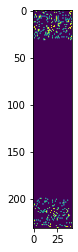

In [ ]:
#try this to see how it connects them, here is where updated cost raster important to follow lines
twr_raster_clean, new_aff = rasterize_inferred_twrs(tif = fn, twrs = combined_twr_df, upscale_factor = .001, threshold = .9)
plt.imshow(twr_raster_clean, cmap='viridis')
#print(np.amin(twr_raster))
target_list = np.argwhere(twr_raster_clean == 1.0)
print(len(target_list))

140


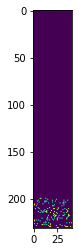

In [ ]:
twr_raster_clean, new_aff = rasterize_inferred_twrs(tif = fn, twrs = inferred_gh_twrs_rev, upscale_factor = .001, threshold = .9)
plt.imshow(twr_raster_clean, cmap='viridis')
#print(np.amin(twr_raster))
target_list = np.argwhere(twr_raster_clean == 1.0)
print(len(target_list))

In [ ]:
targets_out = '/content/drive/MyDrive/PyPSA_Africa_images/models/outlier_detection/outputs/targets_filtered.tif'
save_raster(targets_out, twr_raster_clean, new_aff)

In [ ]:
roads_in ='/content/drive/MyDrive/PyPSA_Africa_images/models/outlier_detection/inputs/gh_full_osm.gpkg'
roads_out ='/content/drive/MyDrive/PyPSA_Africa_images/models/outlier_detection/outputs/roads.tif'

#extract roads and osm data

In [ ]:
import os
from math import sqrt
import json
from pathlib import Path

import numpy as np
from scipy import signal

import fiona
import rasterio
from rasterio.mask import mask
from rasterio.features import rasterize
from rasterio import Affine
from rasterio.warp import reproject, Resampling

import geopandas as gpd

#roads_in ='/content/drive/MyDrive/PyPSA_Africa_images/models/outlier_detection/inputs/gh_roads_coverage.gpkg'
#roads_in ='/content/drive/MyDrive/PyPSA_Africa_images/models/outlier_detection/inputs/gh_full_roads.gpkg'
roads_in ='/content/drive/MyDrive/PyPSA_Africa_images/models/outlier_detection/inputs/gh_full_osm.gpkg'
roads_out ='/content/drive/MyDrive/PyPSA_Africa_images/models/outlier_detection/outputs/roads.tif'

In [ ]:
def rasterize_road_osm_data(roads_in, aoi_in, twr_raster_in):
    """Prepare a roads feature layer for use in algorithm.
    Parameters
    ----------
    roads_in : str, Path
        Path to a roads feature layer. This implementation is specific to
        OSM data and won't assign proper weights to other data inputs.
    aoi_in : str, Path or GeoDataFrame
        AOI to clip roads.
    twr_raster_in:  Path to a raster file, only used for correct shape and
        affine of roads raster.
            Returns
    -------
    roads_raster : numpy array
        Roads as a raster array with the value being the cost of traversing.
    affine : affine.Affine
        Affine raster transformation for the new raster (same as ntl_in).
    """
    twr_rst = rasterio.open(twr_raster_in)
    shape = twr_rst.shape
    affine = twr_rst.transform

    if isinstance(aoi_in, gpd.GeoDataFrame):
        aoi = aoi_in
    else:
        aoi = gpd.read_file(aoi_in)

    aoi = aoi.set_crs(epsg=4326)
    roads_masked = gpd.read_file(roads_in, mask = aoi)
    roads = gpd.sjoin(roads_masked, aoi, how="inner", op="intersects")
    roads = roads[roads_masked.columns]

    roads["weight"] = 1
    roads.loc[roads["highway"] == "motorway", "weight"] = 1 / 10
    roads.loc[roads["highway"] == "trunk", "weight"] = 1 / 9
    roads.loc[roads["highway"] == "primary", "weight"] = 1 / 8
    roads.loc[roads["highway"] == "secondary", "weight"] = 1 / 7
    roads.loc[roads["highway"] == "tertiary", "weight"] = 1 / 6
    roads.loc[roads["highway"] == "unclassified", "weight"] = 1 / 5
    roads.loc[roads["highway"] == "residential", "weight"] = 1 / 4
    roads.loc[roads["highway"] == "service", "weight"] = 1 / 3
    roads.loc[roads["highway"] == "trailhead", "weight"] = 1 / 2

    # Power lines get weight 0
    # Note that this means both transportation AND power categories should be included when importing from OSM
    if "power" in roads:
        roads.loc[roads["power"] == "line", "weight"] = 0

    roads = roads[roads.weight != 1]

    # sort by weight descending so that lower weight (bigger roads) are
    # processed last and overwrite higher weight roads
    roads = roads.sort_values(by="weight", ascending=False)

    geom_value = ((geom,value) for geom, value in zip(roads.geometry, roads.weight))

    roads_raster = rasterize(
        geom_value,
        out_shape=shape,
        fill=1,
        default_value=0,
        all_touched=True,
        transform= transform,
    )

    return roads_raster, affine

##cost estimations

note that here the lines should show once we import full osm data

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


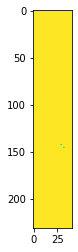

In [ ]:
roads_raster, affine = rasterize_road_osm_data(roads_in, aoi, targets_out)
plt.imshow(roads_raster, cmap='viridis', vmin=0, vmax=1)

In [ ]:
save_raster(roads_out, roads_raster, affine, nodata=-1)

#load computed targets and costs

In [ ]:
def get_targets_costs(targets_in, costs_in):
    """Load the targets and costs arrays from the given file paths.
    Parameters
    ----------
    targets_in : str
        Path for targets raster.
    costs_in : str
        Path for costs raster.
    Returns
    -------
    targets : numpy array
        2D array of targets
    costs: numpy array
        2D array of costs
    start: tuple
        Two-element tuple with row, col of starting point.
    affine : affine.Affine
        Affine transformation for the rasters.
    """

    targets_ra = rasterio.open(targets_in)
    affine = targets_ra.transform
    targets = targets_ra.read(1)

    costs_ra = rasterio.open(costs_in)
    costs = costs_ra.read(1)

    target_list = np.argwhere(targets == 1.0)
    start = tuple(target_list[0].tolist())

    targets = targets.astype(np.int8)
    costs = costs.astype(np.float16)

    return targets, costs, start, affine

#optimise distances

In [ ]:
import os
import sys
from math import sqrt
from heapq import heapify, heappush, heappop
import pickle

import numpy as np
import rasterio
from IPython.display import display, Markdown
from skimage.morphology import skeletonize

from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
from skimage.morphology import skeletonize
import shapely.wkt
from shapely.geometry import Point, LineString
import rasterio
from rasterio.features import rasterize
from rasterio.transform import xy

def optimise(
    targets,
    costs,
    start,
    jupyter=False,
    animate=False,
    affine=None,
    animate_path=None,
    silent=False,
):
    """Run the Dijkstra algorithm for the supplied arrays.
    Parameters
    ----------
    targets : numpy array
        2D array of targets.
    costs : numpy array
        2D array of costs.
    start : tuple
        Two-element tuple with row, col of starting point.
    jupyter : boolean, optional (default False)
        Whether the code is being run from a Jupyter Notebook.
    Returns
    -------
    dist : numpy array
        2D array with the distance (in cells) of each point from a 'found'
        on-grid point. Values of 0 imply that cell is part of an MV grid line.
    """

    max_i = costs.shape[0]
    max_j = costs.shape[1]

    visited = np.zeros_like(targets, dtype=np.int8)
    dist = np.full_like(costs, np.nan, dtype=np.float32)

    # want to set this to dtype='int32, int32'
    # but then the if type(prev_loc) == tuple check will break
    # becuas it gets instantiated with tuples
    prev = np.full_like(costs, np.nan, dtype=object)

    dist[start] = 0

    #       dist, loc
    queue = [[0, start]]
    heapify(queue)

    def zero_and_heap_path(loc):
        """Zero the location's distance value and follow upstream doing same.
        Parameters
        ----------
        loc : tuple
            row, col of current point.
        """

        if not dist[loc] == 0:
            dist[loc] = 0
            visited[loc] = 1

            heappush(queue, [0, loc])
            prev_loc = prev[loc]

            if type(prev_loc) == tuple:
                zero_and_heap_path(prev_loc)

    counter = 0
    progress = 0
    max_cells = targets.shape[0] * targets.shape[1]
    if jupyter:
        handle = display(Markdown(""), display_id=True)

    while len(queue):
        current = heappop(queue)
        current_loc = current[1]
        current_i = current_loc[0]
        current_j = current_loc[1]
        current_dist = dist[current_loc]

        for x in range(-1, 2):
            for y in range(-1, 2):
                next_i = current_i + x
                next_j = current_j + y
                next_loc = (next_i, next_j)

                # ensure we're within bounds
                if next_i < 0 or next_j < 0 or next_i >= max_i or next_j >= max_j:
                    continue

                # ensure we're not looking at the same spot
                if next_loc == current_loc:
                    continue

                # skip if we've already set dist to 0
                if dist[next_loc] == 0:
                    continue

                # if the location is connected
                if targets[next_loc]:
                    prev[next_loc] = current_loc
                    zero_and_heap_path(next_loc)

                # otherwise it's a normal queue cell
                else:
                    dist_add = costs[next_loc]
                    if x == 0 or y == 0:  # if this cell is  up/down/left/right
                        dist_add *= 1
                    else:  # or if it's diagonal
                        dist_add *= sqrt(2)

                    next_dist = current_dist + dist_add

                    if visited[next_loc]:
                        if next_dist < dist[next_loc]:
                            dist[next_loc] = next_dist
                            prev[next_loc] = current_loc
                            heappush(queue, [next_dist, next_loc])

                    else:
                        heappush(queue, [next_dist, next_loc])
                        visited[next_loc] = 1
                        dist[next_loc] = next_dist
                        prev[next_loc] = current_loc

                        counter += 1
                        progress_new = 100 * counter / max_cells
                        if int(progress_new) > int(progress):
                            progress = progress_new
                            message = f"{progress:.2f} %"
                            if jupyter:
                                handle.update(message)
                            elif not silent:
                                print(message)
                            if animate:
                                i = int(progress)
                                path = os.path.join(animate_path, f"arr{i:03d}.tif")
                                save_raster(path, dist, affine)

    return dist

def threshold(dists_in, cutoff=0.5):
    """Convert distance array into binary array of connected locations.
    Parameters
    ----------
    dists_in : path-like or numpy array
        2D array output from gridfinder algorithm.
    cutoff : float, optional (default 0.5.)
        Cutoff value below which consider the cells to be grid.
    Returns
    -------
    guess : numpy array
        Binary representation of input array.
    affine: affine.Affine
        Affine transformation for raster.
    """
    if isinstance(dists_in, (str, Path)):
        dists_rd = rasterio.open(dists_in)
        dists_r = dists_rd.read(1)
        affine = dists_rd.transform

        guess = dists_r.copy()
        guess[dists_r > cutoff] = 0
        guess[dists_r <= cutoff] = 1

        return guess, affine

    elif isinstance(dists_in, np.ndarray):
        guess = dists_in.copy()
        guess[dists_in > cutoff] = 0
        guess[dists_in <= cutoff] = 1

        return guess

    else:
        raise ValueError


def thin(guess_in):
    """
    Use scikit-image skeletonize to 'thin' the guess raster.
    Parameters
    ----------
    guess_in : path-like or 2D array
        Output from threshold().
    Returns
    -------
    guess_skel : numpy array
        Thinned version.
    affine : Affine
        Only if path-like supplied.
    """

    if isinstance(guess_in, (str, Path)):
        guess_rd = rasterio.open(guess_in)
        guess_arr = guess_rd.read(1)
        affine = guess_rd.transform

        guess_skel = skeletonize(guess_arr)
        guess_skel = guess_skel.astype("int32")

        return guess_skel, affine

    elif isinstance(guess_in, np.ndarray):
        guess_skel = skeletonize(guess_in)
        guess_skel = guess_skel.astype("int32")

        return guess_skel

    else:
        raise ValueError


def raster_to_lines(guess_skel_in):
    """
    Convert thinned raster to linestring geometry.
    Parameters
    ----------
    guess_skel_in : path-like
        Output from thin().
    Returns
    -------
    guess_gdf : GeoDataFrame
        Converted to geometry.
    """

    rast = rasterio.open(guess_skel_in)
    arr = rast.read(1)
    affine = rast.transform

    max_row = arr.shape[0]
    max_col = arr.shape[1]
    lines = []

    for row in range(0, max_row):
        for col in range(0, max_col):
            loc = (row, col)
            if arr[loc] == 1:
                for i in range(-1, 2):
                    for j in range(-1, 2):
                        next_row = row + i
                        next_col = col + j
                        next_loc = (next_row, next_col)

                        # ensure we're within bounds
                        # ensure we're not looking at the same spot
                        if (
                            next_row < 0
                            or next_col < 0
                            or next_row >= max_row
                            or next_col >= max_col
                            or next_loc == loc
                        ):
                            continue

                        if arr[next_loc] == 1:
                            line = (loc, next_loc)
                            rev = (line[1], line[0])
                            if line not in lines and rev not in lines:
                                lines.append(line)

    real_lines = []
    for line in lines:
        real = (xy(affine, line[0][0], line[0][1]), xy(affine, line[1][0], line[1][1]))
        real_lines.append(real)

    shapes = []
    for line in real_lines:
        shapes.append(LineString([Point(line[0]), Point(line[1])]).wkt)

    guess_gdf = pd.DataFrame(shapes)
    geometry = guess_gdf[0].map(shapely.wkt.loads)
    guess_gdf = guess_gdf.drop(0, axis=1)
    guess_gdf = gpd.GeoDataFrame(guess_gdf, crs=rast.crs, geometry=geometry)

    guess_gdf["same"] = 0
    guess_gdf = guess_gdf.dissolve(by="same")
    guess_gdf = guess_gdf.to_crs(epsg=4326)

    return guess_gdf

#results

In [ ]:
targets, costs, start, affine = get_targets_costs(targets_out, roads_out)


'98.00 %'

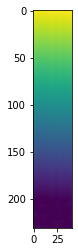

In [ ]:
dist = optimise(targets, costs, start,
                   jupyter=True,
                   animate=False,
                   affine=affine)

plt.imshow(dist)

Got guess


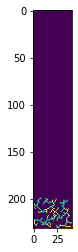

In [ ]:
guess_out = '/content/drive/MyDrive/PyPSA_Africa_images/models/outlier_detection/outputs/guess.tif'
guess = threshold(dist, cutoff = .5)
save_raster(guess_out, guess, affine)
guess_skel = thin(guess)
print('Got guess')
plt.imshow(guess, cmap='viridis')

In [ ]:
guess_skel_out = '/content/drive/MyDrive/PyPSA_Africa_images/models/outlier_detection/outputs/guess_skel.tif'
guess_skel = thin(guess)
save_raster(guess_skel_out, guess_skel, affine)

In [ ]:
guess_gdf = raster_to_lines(guess_skel_out)

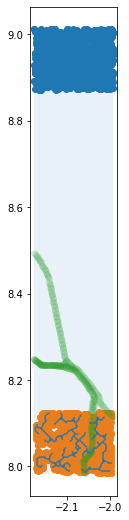

In [ ]:
import matplotlib.pyplot as plt
_, ax = plt.subplots(1, 1, figsize=(16, 9))
inferred_gh_twrs.plot(ax=ax)
inferred_gh_twrs_rev.plot(ax=ax)
aoi.plot(ax=ax, alpha=0.1)
guess_gdf.plot(ax = ax, alpha = .9)
targets_df.plot(ax=ax, alpha = .1)
plt.show()

#note now build method with also optional outolier detection

#folium

In [ ]:
minx, miny, maxx, maxy = list(guess_gdf.bounds.iloc[0])
bounds = ((miny, minx), (maxy, maxx))

m = folium.Map(control_scale=True)
m.fit_bounds(bounds)
folium.GeoJson(guess_gdf).add_to(m)
m

In [ ]:
minx, miny, maxx, maxy = list(guess_gdf.bounds.iloc[0])
bounds = ((miny, minx), (maxy, maxx))

m = folium.Map(control_scale=True)
m.fit_bounds(bounds)
folium.GeoJson(guess_gdf).add_to(m)
m